In [1]:
import logging
import math
from pathlib import Path

import cv2
import scipy.sparse
import scipy.spatial
import fire
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

In [2]:
from modules.danbooru import Danbooru
from modules.label_rect import label

In [3]:
path = '../../danbooru/resized/images/1321019.jpg'

In [4]:
src = cv2.imread(path)
src_gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)

height, width = src.shape[:2]

high_thresh, thresh_im = cv2.threshold(src_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
low_thresh = 0.5*high_thresh
edges = cv2.Canny(src_gray, low_thresh, high_thresh)

invert_gray_image = cv2.bitwise_not(src_gray)
sobel_x = cv2.Sobel(invert_gray_image, cv2.CV_64F, 1, 0)
sobel_y = cv2.Sobel(invert_gray_image, cv2.CV_64F, 0, 1)

magnitude, direction = cv2.cartToPolar(sobel_x, sobel_y)

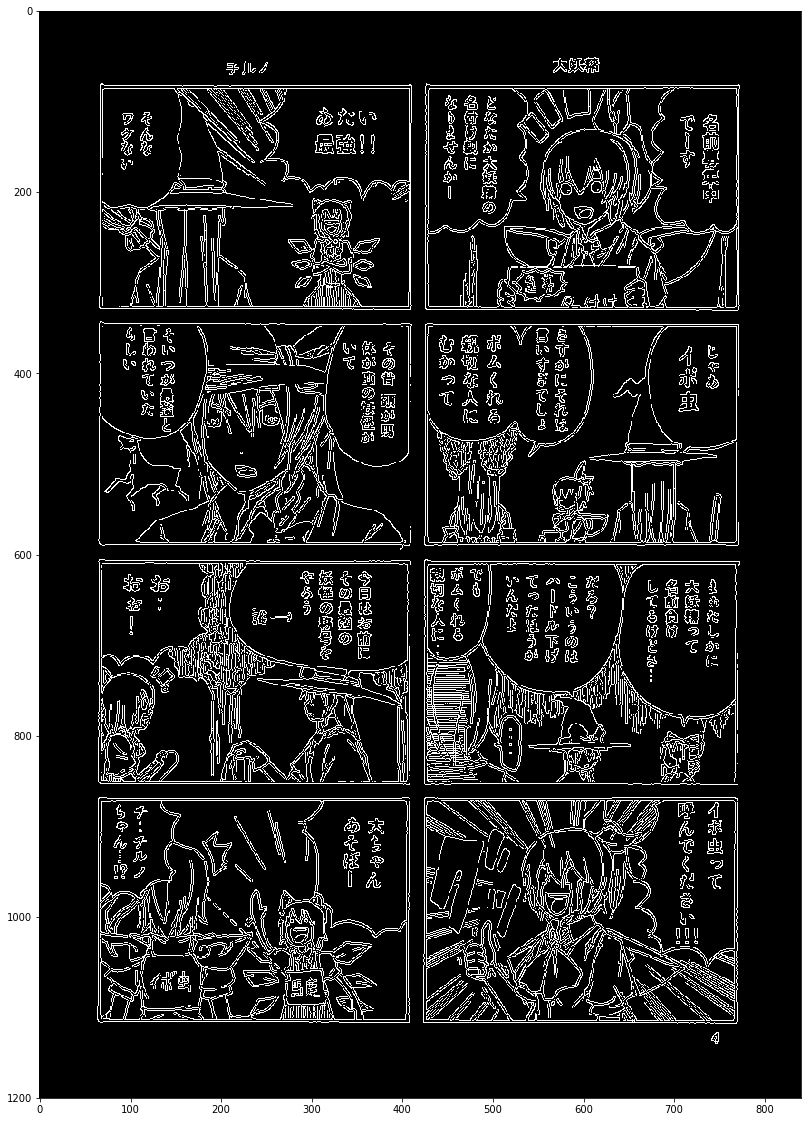

In [5]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(edges, cmap="gray")

In [6]:
import math
import numpy as np
import logging

def get_swt(edges, sobel_x, sobel_y, direction, magnitude, height, width) -> np.ndarray:
    rays = []
    swt = np.full(edges.shape, np.Infinity)

    # Ignore error from divide by zero
    np.seterr(divide='ignore', invalid='ignore')

    step_x_g, step_y_g = sobel_x, sobel_y

    gradient_x_init = np.divide(step_x_g, magnitude)
    gradient_y_init = np.divide(step_y_g, magnitude)

    for y in range(height):
        for x in range(width):
            if edges[y][x] == 0:
                continue

            gradient_x = gradient_x_init[y, x]
            gradient_y = gradient_y_init[y, x]

            ray = [{'x': x, 'y': y}]
            i = 0

            while True:
                i += 1

                try:
                    cur_x = math.floor(x + gradient_x * i)
                    cur_y = math.floor(y + gradient_y * i)

                except ValueError:
                    # Catch Nan value when currently position reached to outside a image
                    break

                try:
                    ray.append({'x': cur_x, 'y': cur_y})

                    # IF still not found the another edge THEN go to next step
                    if edges[cur_y][cur_x] == 0:
                        continue

                    # Difference between the direction of start edge and another edge
                    # IF difference is exceed 90degree THEN ignore this ray
                    if abs(abs(round(np.degrees(direction[y, x])) - round(np.degrees(direction[cur_y, cur_x]))) - 180) >= 60:
                        break

                    thickness = math.sqrt((cur_x - x) * (cur_x - x) + (cur_y - y) * (cur_y - y))
                    rays.append(ray)

                    for pos in ray:
                        swt[pos['y'], pos['x']] = min(thickness, swt[pos['y'], pos['x']])

                    break

                except IndexError:
                        break

    for ray in rays:
        median = np.median([swt[pos['y'], pos['x']] for pos in ray])

        for pos in ray:
            swt[pos['y'], pos['x']] = min(median, swt[pos['y'], pos['x']])

    logging.getLogger(__name__).info('Finished.')

    return swt


In [7]:
swt = get_swt(edges, sobel_x, sobel_y, direction, magnitude, height, width)

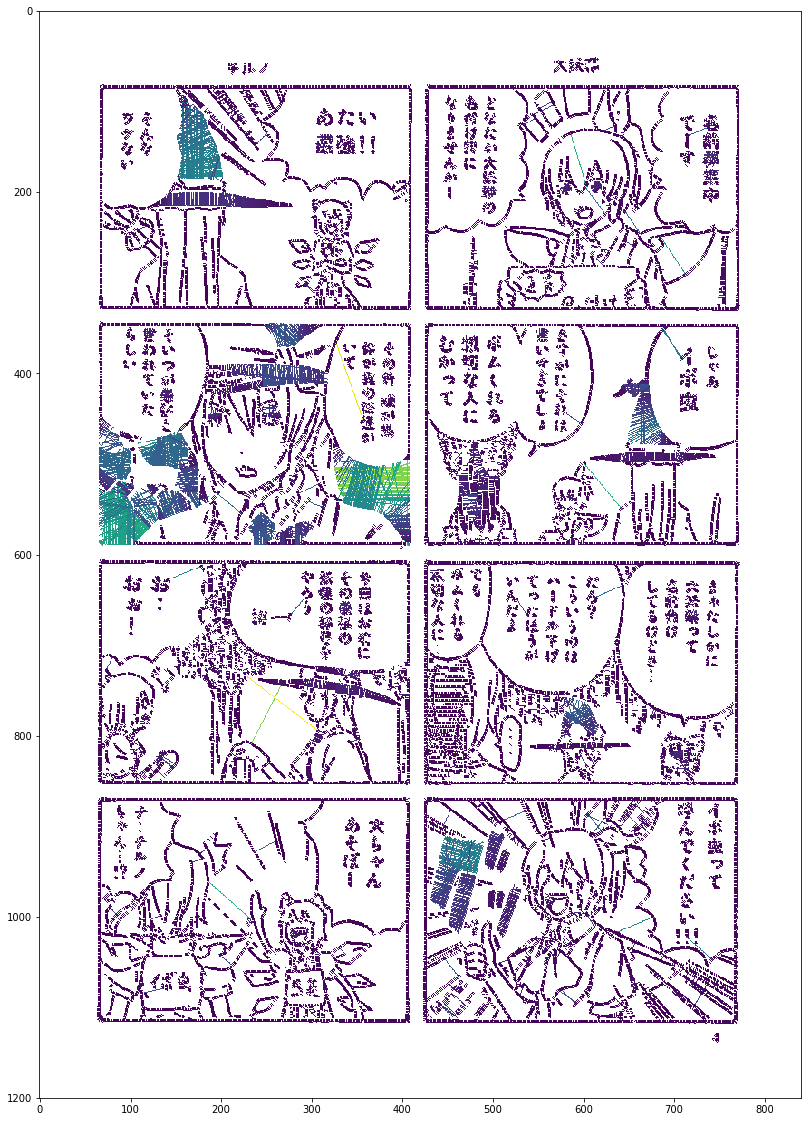

In [8]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(swt)

In [9]:
import logging

import numpy as np


def get_connected_components(swt: np.ndarray):
    class Label(object):
        def __init__(self, value):
            self.value = value
            self.parent = self
            self.rank = 0

    ld = {}

    def make_set(x):
        try:
            return ld[x]
        except KeyError:
            item = Label(x)
            ld[x] = item
            return item

    def find(item):
        if item.parent != item:
            item.parent = find(item.parent)

        return item.parent

    def union(x, y):
        """
        :param x:
        :param y:
        :return: root node of new union tree
        """
        x_root = find(x)
        y_root = find(y)
        if x_root == y_root:
            return x_root

        if x_root.rank < y_root.rank:
            x_root.parent = y_root
            return y_root
        elif x_root.rank > y_root.rank:
            y_root.parent = x_root
            return x_root
        else:
            y_root.parent = x_root
            x_root.rank += 1
            return x_root

    trees = {}
    label_map = np.zeros(shape=swt.shape, dtype=np.uint16)
    next_label = 1

    swt_ratio_threshold = 3

    for y in range(swt.shape[0]):
        for x in range(swt.shape[1]):

            sw_point = swt[y, x]
            if 0 < sw_point < np.Infinity:
                neighbors = [(y, x - 1),  # west
                             (y - 1, x - 1),  # northwest
                             (y - 1, x),  # north
                             (y - 1, x + 1)]  # northeast
                connected_neighbors = None
                neighbor_values = []

                for neighbor in neighbors:
                    try:
                        sw_n = swt[neighbor]
                        label_n = label_map[neighbor]
                    except IndexError:
                        continue
                    if label_n > 0 and sw_n / sw_point < swt_ratio_threshold and sw_point / sw_n < swt_ratio_threshold:
                        neighbor_values.append(label_n)
                        if connected_neighbors:
                            connected_neighbors = union(connected_neighbors, make_set(label_n))
                        else:
                            connected_neighbors = make_set(label_n)

                if not connected_neighbors:
                    trees[next_label] = make_set(next_label)
                    label_map[y, x] = next_label
                    next_label += 1
                else:
                    label_map[y, x] = min(neighbor_values)
                    trees[connected_neighbors.value] = union(trees[connected_neighbors.value], connected_neighbors)

    layers = {}
    for x in range(swt.shape[1]):
        for y in range(swt.shape[0]):
            if label_map[y, x] <= 0:
                continue

            item = ld[label_map[y, x]]
            common_label = find(item).value
            label_map[y, x] = common_label

            try:
                layer = layers[common_label]
            except KeyError:
                layers[common_label] = np.zeros(shape=swt.shape, dtype=np.uint8)
                layer = layers[common_label]

            layer[y, x] = 1

    logging.getLogger(__name__).info('Finished.')

    return layers, label_map


In [10]:
connected_components, label_map = get_connected_components(swt)

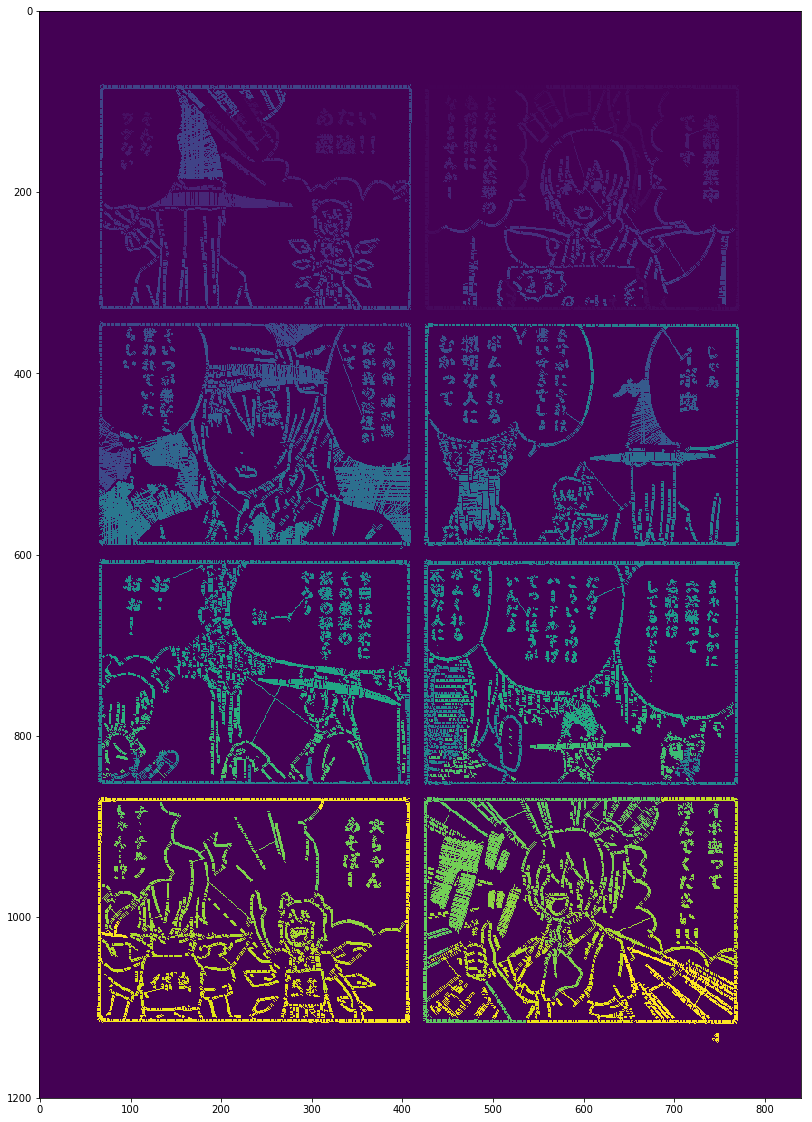

In [11]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(label_map)

In [31]:
import logging
import math

import numpy as np

def get_letters(swt: np.ndarray, connected_components: dict):
    heights, widths, topleft_pts, swt_values = [], [], [], []

    for label, layer in connected_components.items():
        nz_y, nz_x = np.nonzero(layer)
        east, west, south, north = max(nz_x), min(nz_x), max(nz_y), min(nz_y)
        width, height = east - west, south - north

        if height <= 10 or height >= 300:
            continue
            
        diameter = math.sqrt(width * width + height * height)
        median_swt = np.median(swt[(nz_y, nz_x)])

        if diameter / median_swt > 10 or diameter / median_swt < 1:
            continue

        heights.append(height)
        topleft_pts.append(np.asarray((north, west)))
        widths.append(width)
        swt_values.append(median_swt)

    logging.getLogger(__name__).info('Finished.')

    return heights, widths, topleft_pts, swt_values


In [32]:
heights, widths, topleft_pts, swt_values = get_letters(swt, connected_components)

In [33]:
def get_words(swts, heights, widths, topleft_pts):
    swts_array = np.asarray([[math.log(i, 2)] for i in swts])
    heights_array = np.asarray([[math.log(i, 2)] for i in heights])
    
    swt_tree = scipy.spatial.KDTree(swts_array)
    stp = swt_tree.query_pairs(1)

    height_tree = scipy.spatial.KDTree(heights_array)
    htp = set(height_tree.query_pairs(1))

    isect = htp.intersection(stp)

    chains = []
    pairs = []
    pair_angles = []
    for pair in isect:
        left = pair[0]
        right = pair[1]
        widest = max(widths[left], widths[right])
        distance = np.linalg.norm(topleft_pts[left] - topleft_pts[right])
        if distance < widest * 3:
            delta_yx = topleft_pts[left] - topleft_pts[right]
            angle = np.arctan2(delta_yx[0], delta_yx[1])
            if angle < 0:
                angle += np.pi

            pairs.append(pair)
            pair_angles.append(np.asarray([angle]))

    if len(pair_angles) == 0:
        return []

    angle_tree = scipy.spatial.KDTree(np.asarray(pair_angles))
    atp = angle_tree.query_pairs(np.pi / 12)

    for pair_idx in atp:
        pair_a = pairs[pair_idx[0]]
        pair_b = pairs[pair_idx[1]]
        left_a = pair_a[0]
        right_a = pair_a[1]
        left_b = pair_b[0]
        right_b = pair_b[1]

        added = False
        for chain in chains:
            if left_a in chain:
                chain.add(right_a)
                added = True
            elif right_a in chain:
                chain.add(left_a)
                added = True

        if not added:
            chains.append({left_a, right_a})

        added = False
        for chain in chains:
            if left_b in chain:
                chain.add(right_b)
                added = True
            elif right_b in chain:
                chain.add(left_b)
                added = True

        if not added:
            chains.append({left_b, right_b})

    words = []

    for chain in set([tuple(i) for i in chains]):
        word_swts = []
        east_word, west_word, south_word, north_word = 0, np.inf, 0, np.inf

        for idx in chain:
            north, west = topleft_pts[idx]
            south, east = north + heights[idx], west + widths[idx]

            east_word = max(east_word, east)
            west_word = min(west_word, west)
            south_word = max(south_word, south)
            north_word = min(north_word, north)

            word_swts.append(swts[idx])

        width, height = east_word - west_word, south_word - north_word

        words.append({
            'swt': np.median(word_swts),
            'height': height,
            'width': width,
            'topleft_pt': (north_word, west_word)
        })

    logging.getLogger(__name__).info('Finished.')

    return words

In [34]:
words = get_words(swt_values, heights, widths, topleft_pts)

In [35]:
output = src.copy()

widths, heights, topleft_pts = [], [], []
for datum in words:        
    x1, y1 = datum['topleft_pt'][1], datum['topleft_pt'][0]
    x2, y2 = x1 + datum['width'], y1 + datum['height']
    
    cv2.rectangle(
        output,
        (x1, y1),
        (x2, y2),
        (1,0,0),
        2
    )

(106, 1060) (146, 1080)
(171, 978) (177, 1012)
(307, 521) (319, 569)
(437, 1083) (500, 1111)
(134, 417) (267, 459)
(437, 1083) (500, 1111)
(656, 550) (664, 583)
(72, 763) (123, 831)
(92, 114) (124, 160)
(289, 619) (366, 715)
(555, 765) (754, 1089)
(264, 991) (311, 1111)
(432, 906) (531, 1022)
(432, 616) (640, 774)
(576, 314) (617, 326)
(557, 161) (660, 278)
(733, 155) (750, 192)
(191, 898) (230, 954)
(239, 308) (392, 505)
(180, 389) (505, 589)
(89, 433) (141, 475)
(216, 287) (235, 325)
(384, 726) (408, 755)
(488, 1007) (509, 1037)
(446, 95) (504, 224)
(567, 529) (581, 545)
(66, 463) (410, 590)
(661, 115) (749, 212)
(604, 624) (616, 671)
(305, 109) (370, 158)
(535, 754) (554, 789)
(103, 285) (114, 322)
(557, 161) (660, 278)
(670, 630) (749, 724)
(670, 272) (689, 297)
(670, 630) (749, 724)
(93, 570) (248, 739)
(495, 971) (513, 990)
(670, 630) (749, 724)
(446, 95) (504, 224)
(506, 553) (514, 569)
(446, 95) (504, 224)
(575, 189) (620, 203)
(179, 458) (187, 471)
(189, 58) (264, 155)
(336, 8

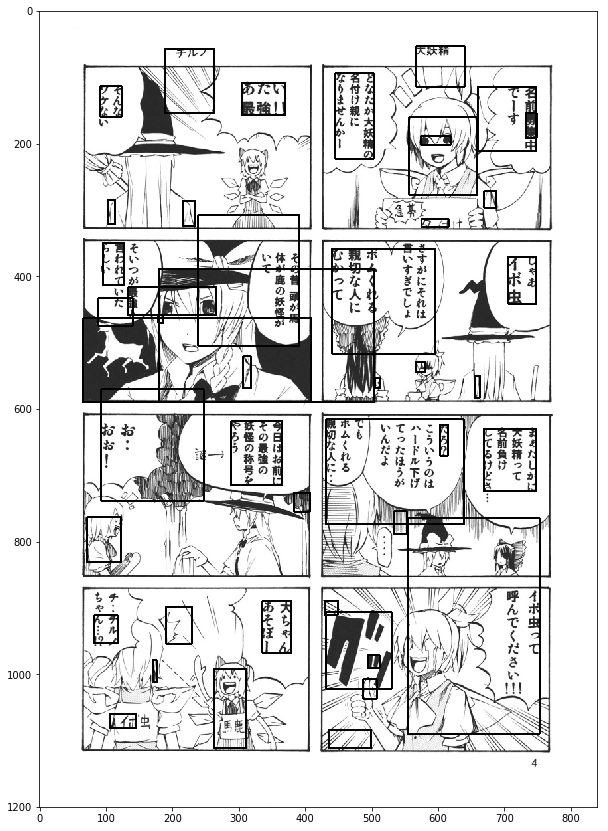

In [36]:
fig, ax = plt.subplots(figsize=(10, 20))
ax.imshow(output)